In [22]:
import os, sys

def get_dir_n_levels_up(path, n):
    # Go up n levels from the given path
    for _ in range(n):
        path = os.path.dirname(path)
    return path

proj_root = get_dir_n_levels_up(os.path.abspath("__file__"), 4)
sys.path.append(proj_root)

import pandas as pd
import yaml
import torch
import collections

import warnings
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt
sns.set_theme()

warnings.filterwarnings("ignore")

from dqn.opinion_dynamics.utils.experiment import process_experiment


In [23]:
experiment_sub_dir = "2025Apr29-212301_configs"
exp_path = os.path.join(r"D:\Work\repos\RL\phd-rl-algos\dqn\opinion_dynamics\experiments\results", experiment_sub_dir)
df = process_experiment(
    exp_path
)
df.columns


Index(['epoch_type', 'frame_stamp', 'episode_rewards_min',
       'episode_rewards_max', 'episode_rewards_mean', 'episode_rewards_median',
       'episode_rewards_std', 'episode_discounted_rewards_min',
       'episode_discounted_rewards_max', 'episode_discounted_rewards_mean',
       'episode_discounted_rewards_median', 'episode_discounted_rewards_std',
       'episode_frames_min', 'episode_frames_max', 'episode_frames_mean',
       'episode_frames_median', 'episode_frames_std', 'episode_losses_min',
       'episode_losses_max', 'episode_losses_mean', 'episode_losses_median',
       'episode_losses_std', 'episode_max_qs_min', 'episode_max_qs_max',
       'episode_max_qs_mean', 'episode_max_qs_median', 'episode_max_qs_std',
       'policy_trained_times', 'target_trained_times', 'epoch_time',
       'sub_exp_cfg_optim.args_.eps', 'sub_exp_cfg_optim.args_.lr',
       'sub_exp_cfg_agent_params.args_.action_w_noise_amplitude',
       'sub_experiment_path', 'seed', 'experiment_name'],
     

In [24]:
df

,epoch_type,frame_stamp,episode_rewards_min,episode_rewards_max,episode_rewards_mean,episode_rewards_median,episode_rewards_std,episode_discounted_rewards_min,episode_discounted_rewards_max,episode_discounted_rewards_mean,...,episode_max_qs_std,policy_trained_times,target_trained_times,epoch_time,sub_exp_cfg_optim.args_.eps,sub_exp_cfg_optim.args_.lr,sub_exp_cfg_agent_params.args_.action_w_noise_amplitude,sub_experiment_path,seed,experiment_name
0,training,200000,-5.992285,-5.883884,-5.910625,-5.903892,0.023136,-4.022730,-3.975372,-3.987411,...,0.594258,24374.0,48.0,0 days 00:03:30.748398,1e-06,1e-05,0,D:\Work\repos\RL\phd-rl-algos\dqn\opinion_dyna...,0,0000_optim.args_.eps_1e-06__optim.args_.lr_1e-...
1,training,400000,-6.278980,-5.927457,-6.087937,-6.090028,0.108271,-4.071730,-3.989280,-4.028204,...,0.945423,25000.0,48.0,0 days 00:03:37.822773,1e-06,1e-05,0,D:\Work\repos\RL\phd-rl-algos\dqn\opinion_dyna...,0,0000_optim.args_.eps_1e-06__optim.args_.lr_1e-...
2,training,600000,-8.405907,-6.278766,-6.916481,-6.719694,0.562821,-4.324384,-4.071702,-4.166133,...,1.020326,25000.0,48.0,0 days 00:03:45.760029,1e-06,1e-05,0,D:\Work\repos\RL\phd-rl-algos\dqn\opinion_dyna...,0,0000_optim.args_.eps_1e-06__optim.args_.lr_1e-...
3,training,800000,-11.615955,-8.291315,-10.121521,-10.153654,1.020236,-4.690287,-4.318887,-4.510845,...,0.798383,25000.0,48.0,0 days 00:03:48.662777,1e-06,1e-05,0,D:\Work\repos\RL\phd-rl-algos\dqn\opinion_dyna...,0,0000_optim.args_.eps_1e-06__optim.args_.lr_1e-...
4,training,1000000,-11.674427,-8.280123,-10.551581,-10.878217,1.037057,-4.702144,-4.366754,-4.576900,...,0.439915,25000.0,56.0,0 days 00:03:48.816447,1e-06,1e-05,0,D:\Work\repos\RL\phd-rl-algos\dqn\opinion_dyna...,0,0000_optim.args_.eps_1e-06__optim.args_.lr_1e-...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
475,validation,1200000,-7.115927,-7.113015,-7.114379,-7.114405,0.000678,-4.308827,-4.307825,-4.308319,...,0.982434,NaN,NaN,0 days 00:00:00.618510,1e-05,0.0001,0.3,D:\Work\repos\RL\phd-rl-algos\dqn\opinion_dyna...,1,0011_optim.args_.eps_1e-05__optim.args_.lr_0.0...
476,validation,1400000,-7.060246,-7.057299,-7.058725,-7.058764,0.000723,-4.286278,-4.285314,-4.285770,...,0.597170,NaN,NaN,0 days 00:00:00.622092,1e-05,0.0001,0.3,D:\Work\repos\RL\phd-rl-algos\dqn\opinion_dyna...,1,0011_optim.args_.eps_1e-05__optim.args_.lr_0.0...
477,validation,1600000,-5.984716,-5.983834,-5.984304,-5.984296,0.000188,-3.987304,-3.986984,-3.987169,...,0.577389,NaN,NaN,0 days 00:00:00.605818,1e-05,0.0001,0.3,D:\Work\repos\RL\phd-rl-algos\dqn\opinion_dyna...,1,0011_optim.args_.eps_1e-05__optim.args_.lr_0.0...
478,validation,1800000,-5.651755,-5.650994,-5.651426,-5.651445,0.000181,-3.906088,-3.905672,-3.905913,...,0.937368,NaN,NaN,0 days 00:00:00.599777,1e-05,0.0001,0.3,D:\Work\repos\RL\phd-rl-algos\dqn\opinion_dyna...,1,0011_optim.args_.eps_1e-05__optim.args_.lr_0.0...


In [25]:
df[df['epoch_type'] == 'validation']

,epoch_type,frame_stamp,episode_rewards_min,episode_rewards_max,episode_rewards_mean,episode_rewards_median,episode_rewards_std,episode_discounted_rewards_min,episode_discounted_rewards_max,episode_discounted_rewards_mean,...,episode_max_qs_std,policy_trained_times,target_trained_times,epoch_time,sub_exp_cfg_optim.args_.eps,sub_exp_cfg_optim.args_.lr,sub_exp_cfg_agent_params.args_.action_w_noise_amplitude,sub_experiment_path,seed,experiment_name
10,validation,200000,-5.927570,-5.927570,-5.927570,-5.927570,8.881784e-16,-3.989311,-3.989311,-3.989311,...,0.747188,NaN,NaN,0 days 00:00:00.709546,1e-06,1e-05,0,D:\Work\repos\RL\phd-rl-algos\dqn\opinion_dyna...,0,0000_optim.args_.eps_1e-06__optim.args_.lr_1e-...
11,validation,400000,-6.278834,-6.278834,-6.278834,-6.278834,0.000000e+00,-4.071713,-4.071713,-4.071713,...,1.059857,NaN,NaN,0 days 00:00:00.687276,1e-06,1e-05,0,D:\Work\repos\RL\phd-rl-algos\dqn\opinion_dyna...,0,0000_optim.args_.eps_1e-06__optim.args_.lr_1e-...
12,validation,600000,-8.293093,-8.293093,-8.293093,-8.293093,0.000000e+00,-4.319094,-4.319094,-4.319094,...,0.870675,NaN,NaN,0 days 00:00:00.686289,1e-06,1e-05,0,D:\Work\repos\RL\phd-rl-algos\dqn\opinion_dyna...,0,0000_optim.args_.eps_1e-06__optim.args_.lr_1e-...
13,validation,800000,-11.616515,-11.616515,-11.616515,-11.616515,0.000000e+00,-4.690400,-4.690400,-4.690400,...,0.308419,NaN,NaN,0 days 00:00:00.695366,1e-06,1e-05,0,D:\Work\repos\RL\phd-rl-algos\dqn\opinion_dyna...,0,0000_optim.args_.eps_1e-06__optim.args_.lr_1e-...
14,validation,1000000,-8.415282,-8.415282,-8.415282,-8.415282,0.000000e+00,-4.371583,-4.371583,-4.371583,...,0.692391,NaN,NaN,0 days 00:00:00.677172,1e-06,1e-05,0,D:\Work\repos\RL\phd-rl-algos\dqn\opinion_dyna...,0,0000_optim.args_.eps_1e-06__optim.args_.lr_1e-...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
475,validation,1200000,-7.115927,-7.113015,-7.114379,-7.114405,6.782640e-04,-4.308827,-4.307825,-4.308319,...,0.982434,NaN,NaN,0 days 00:00:00.618510,1e-05,0.0001,0.3,D:\Work\repos\RL\phd-rl-algos\dqn\opinion_dyna...,1,0011_optim.args_.eps_1e-05__optim.args_.lr_0.0...
476,validation,1400000,-7.060246,-7.057299,-7.058725,-7.058764,7.230905e-04,-4.286278,-4.285314,-4.285770,...,0.597170,NaN,NaN,0 days 00:00:00.622092,1e-05,0.0001,0.3,D:\Work\repos\RL\phd-rl-algos\dqn\opinion_dyna...,1,0011_optim.args_.eps_1e-05__optim.args_.lr_0.0...
477,validation,1600000,-5.984716,-5.983834,-5.984304,-5.984296,1.876194e-04,-3.987304,-3.986984,-3.987169,...,0.577389,NaN,NaN,0 days 00:00:00.605818,1e-05,0.0001,0.3,D:\Work\repos\RL\phd-rl-algos\dqn\opinion_dyna...,1,0011_optim.args_.eps_1e-05__optim.args_.lr_0.0...
478,validation,1800000,-5.651755,-5.650994,-5.651426,-5.651445,1.812008e-04,-3.906088,-3.905672,-3.905913,...,0.937368,NaN,NaN,0 days 00:00:00.599777,1e-05,0.0001,0.3,D:\Work\repos\RL\phd-rl-algos\dqn\opinion_dyna...,1,0011_optim.args_.eps_1e-05__optim.args_.lr_0.0...


In [26]:
# Define hyperparameter columns
hyperparam_columns = [col for col in df.columns if "sub_exp_cfg" in col]

# Group by hyperparameter values and compute mean episode_rewards_mean
averaged_results = df.groupby(hyperparam_columns, as_index=False).agg({
    'episode_rewards_mean': 'mean',  # Averaging the performance metric
    'sub_experiment_path': 'first'   # Keep a reference to an experiment path
})

# Find the best hyperparameter set based on the highest mean reward
best_row = averaged_results.loc[averaged_results['episode_rewards_mean'].idxmax()]

# Print the best experiment path and hyperparameters
print(f"Best hyperparameters:\n{best_row[hyperparam_columns]}")
print(f"Best mean reward: {best_row['episode_rewards_mean']}")

Best hyperparameters:
sub_exp_cfg_optim.args_.eps                                 1e-05
sub_exp_cfg_optim.args_.lr                                 0.0001
sub_exp_cfg_agent_params.args_.action_w_noise_amplitude       0.1
Name: 1, dtype: object
Best mean reward: -6.1538563314326815


In [27]:
averaged_results

,sub_exp_cfg_optim.args_.eps,sub_exp_cfg_optim.args_.lr,sub_exp_cfg_agent_params.args_.action_w_noise_amplitude,episode_rewards_mean,sub_experiment_path
0,1e-05,0.0001,0,-7.405618,D:\Work\repos\RL\phd-rl-algos\dqn\opinion_dyna...
1,1e-05,0.0001,0.1,-6.153856,D:\Work\repos\RL\phd-rl-algos\dqn\opinion_dyna...
2,1e-05,0.0001,0.3,-6.584434,D:\Work\repos\RL\phd-rl-algos\dqn\opinion_dyna...
3,1e-05,1e-05,0,-7.432921,D:\Work\repos\RL\phd-rl-algos\dqn\opinion_dyna...
4,1e-05,1e-05,0.1,-7.151418,D:\Work\repos\RL\phd-rl-algos\dqn\opinion_dyna...
5,1e-05,1e-05,0.3,-7.488453,D:\Work\repos\RL\phd-rl-algos\dqn\opinion_dyna...
6,1e-06,0.0001,0,-9.364588,D:\Work\repos\RL\phd-rl-algos\dqn\opinion_dyna...
7,1e-06,0.0001,0.1,-6.435435,D:\Work\repos\RL\phd-rl-algos\dqn\opinion_dyna...
8,1e-06,0.0001,0.3,-6.964148,D:\Work\repos\RL\phd-rl-algos\dqn\opinion_dyna...
9,1e-06,1e-05,0,-7.402122,D:\Work\repos\RL\phd-rl-algos\dqn\opinion_dyna...


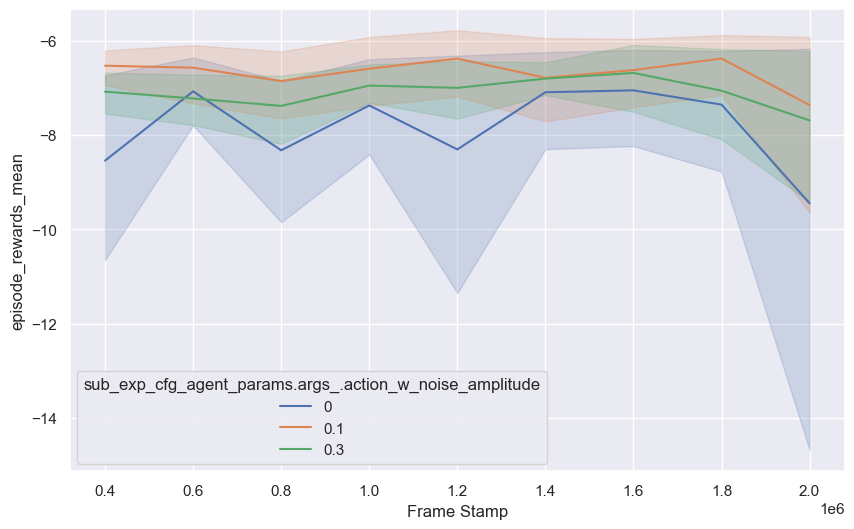

In [28]:
selected_metric = 'episode_rewards_mean'
hue_col = "sub_exp_cfg_agent_params.args_.action_w_noise_amplitude"

# Filter for validation episodes
validation_df = df[df['epoch_type'] == 'validation']

# Get the unique sorted frame_stamp values
unique_frames = np.sort(validation_df['frame_stamp'].unique())
N = 1
# Get all frame_stamp values after the first N unique ones
filtered_frames = unique_frames[N:]

# Filter the DataFrame to only include rows with these frame_stamp values
filtered_df = validation_df[validation_df['frame_stamp'].isin(filtered_frames)]

plt.figure(figsize=(10, 6))
sns.lineplot(data=filtered_df, x='frame_stamp', y=selected_metric, hue=hue_col)
plt.ylabel(selected_metric)
plt.xlabel('Frame Stamp')
plt.show()

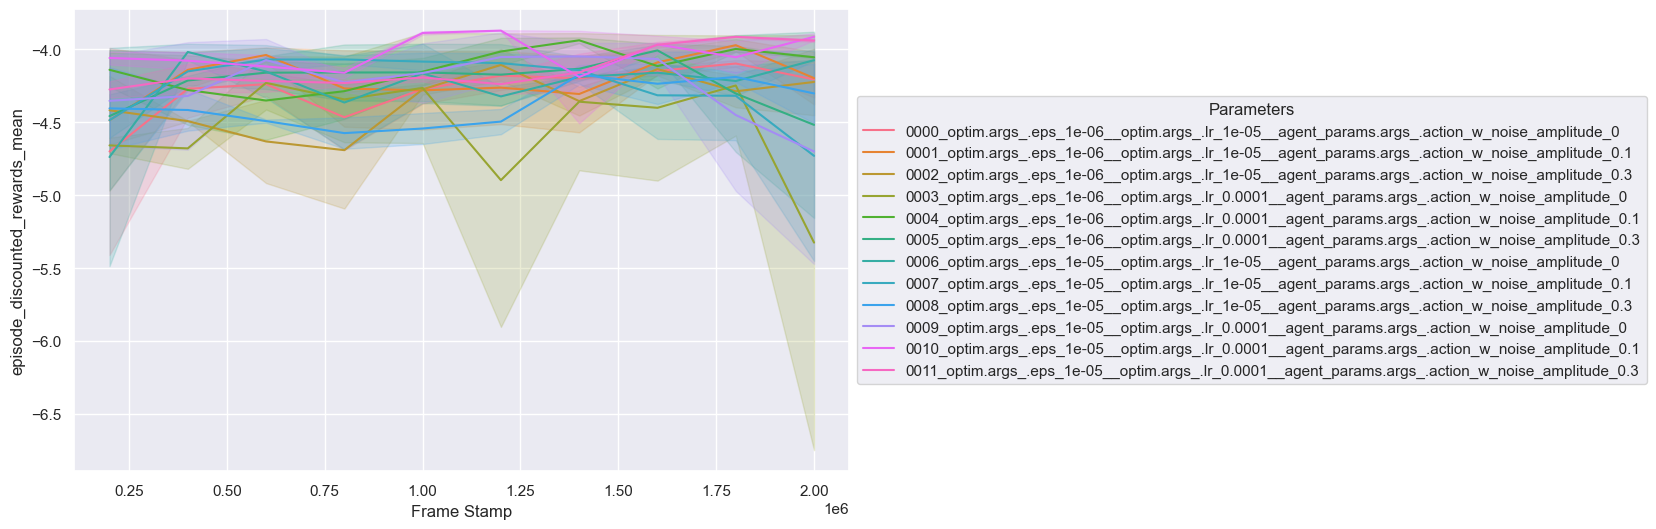

In [29]:

selected_metric = 'episode_discounted_rewards_mean'
# hue_col = "sub_exp_cfg_agent_params.args_.action_w_noise_amplitude"
hue_col = "experiment_name"

validation_df = df[df['epoch_type'] == 'validation']


# Create a new figure for each environment
plt.figure(figsize=(10, 6))
# sns.lineplot(data=df, x='frame_stamp', y=selected_metric, hue='model')
sns.lineplot(data=validation_df, x='frame_stamp', y=selected_metric, hue=hue_col)

plt.ylabel(selected_metric)
plt.xlabel('Frame Stamp')

# Place the legend outside the plot
plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5), title='Parameters')
plt.show()

In [30]:
### Select data

experiment_columns = [
    'epoch_type', 'frame_stamp',
    'episode_rewards_mean', 'episode_frames_mean', 
    'episode_discounted_rewards_mean',
    'policy_trained_times', 'target_trained_times', 'epoch_time', 
       'seed', 'experiment_name', "sub_experiment_path"
]
hyperparam_columns = [
   col for col in df.columns if "sub_exp_cfg" in col
]

cols_of_interest = experiment_columns + hyperparam_columns

sub_df = df[cols_of_interest]
sub_df = sub_df[sub_df['epoch_type'] == 'validation']
sub_df = sub_df[sub_df['frame_stamp'] == sub_df['frame_stamp'].max()]

sub_df 


,epoch_type,frame_stamp,episode_rewards_mean,episode_frames_mean,episode_discounted_rewards_mean,policy_trained_times,target_trained_times,epoch_time,seed,experiment_name,sub_experiment_path,sub_exp_cfg_optim.args_.eps,sub_exp_cfg_optim.args_.lr,sub_exp_cfg_agent_params.args_.action_w_noise_amplitude
19,validation,2000000,-6.310367,20.0,-4.082868,NaN,NaN,0 days 00:00:00.670279,0,0000_optim.args_.eps_1e-06__optim.args_.lr_1e-...,D:\Work\repos\RL\phd-rl-algos\dqn\opinion_dyna...,1e-06,1e-05,0
39,validation,2000000,-7.082287,22.0,-4.328680,NaN,NaN,0 days 00:00:00.696509,1,0000_optim.args_.eps_1e-06__optim.args_.lr_1e-...,D:\Work\repos\RL\phd-rl-algos\dqn\opinion_dyna...,1e-06,1e-05,0
59,validation,2000000,-5.983140,18.0,-4.015553,NaN,NaN,0 days 00:00:00.687000,0,0001_optim.args_.eps_1e-06__optim.args_.lr_1e-...,D:\Work\repos\RL\phd-rl-algos\dqn\opinion_dyna...,1e-06,1e-05,0.1
79,validation,2000000,-8.317317,31.0,-4.376575,NaN,NaN,0 days 00:00:00.670361,1,0001_optim.args_.eps_1e-06__optim.args_.lr_1e-...,D:\Work\repos\RL\phd-rl-algos\dqn\opinion_dyna...,1e-06,1e-05,0.1
99,validation,2000000,-8.957201,34.0,-4.450680,NaN,NaN,0 days 00:00:00.654776,0,0002_optim.args_.eps_1e-06__optim.args_.lr_1e-...,D:\Work\repos\RL\phd-rl-algos\dqn\opinion_dyna...,1e-06,1e-05,0.3
119,validation,2000000,-6.018168,19.0,-3.994540,NaN,NaN,0 days 00:00:00.623337,1,0002_optim.args_.eps_1e-06__optim.args_.lr_1e-...,D:\Work\repos\RL\phd-rl-algos\dqn\opinion_dyna...,1e-06,1e-05,0.3
139,validation,2000000,-26.992223,50.0,-6.747869,NaN,NaN,0 days 00:00:00.693948,0,0003_optim.args_.eps_1e-06__optim.args_.lr_0.0...,D:\Work\repos\RL\phd-rl-algos\dqn\opinion_dyna...,1e-06,0.0001,0
159,validation,2000000,-5.653665,17.0,-3.900672,NaN,NaN,0 days 00:00:00.624023,1,0003_optim.args_.eps_1e-06__optim.args_.lr_0.0...,D:\Work\repos\RL\phd-rl-algos\dqn\opinion_dyna...,1e-06,0.0001,0
179,validation,2000000,-6.115143,19.0,-4.049034,NaN,NaN,0 days 00:00:00.649913,0,0004_optim.args_.eps_1e-06__optim.args_.lr_0.0...,D:\Work\repos\RL\phd-rl-algos\dqn\opinion_dyna...,1e-06,0.0001,0.1
199,validation,2000000,-6.223969,20.0,-4.057608,NaN,NaN,0 days 00:00:00.631920,1,0004_optim.args_.eps_1e-06__optim.args_.lr_0.0...,D:\Work\repos\RL\phd-rl-algos\dqn\opinion_dyna...,1e-06,0.0001,0.1


In [31]:
agg_cols = [col for col in sub_df.columns if "sub_exp_cfg_agent_params" in col]
aggregated_df = (
    sub_df.groupby(agg_cols)
    .agg(episode_discounted_rewards_mean=("episode_discounted_rewards_mean", "mean"))
    .reset_index()
)
aggregated_df

,sub_exp_cfg_agent_params.args_.action_w_noise_amplitude,episode_discounted_rewards_mean
0,0,-4.575738
1,0.1,-4.222961
2,0.3,-4.244992


In [32]:
sub_df.columns

Index(['epoch_type', 'frame_stamp', 'episode_rewards_mean',
       'episode_frames_mean', 'episode_discounted_rewards_mean',
       'policy_trained_times', 'target_trained_times', 'epoch_time', 'seed',
       'experiment_name', 'sub_experiment_path', 'sub_exp_cfg_optim.args_.eps',
       'sub_exp_cfg_optim.args_.lr',
       'sub_exp_cfg_agent_params.args_.action_w_noise_amplitude'],
      dtype='object')

In [33]:
sub_df[[
    "episode_discounted_rewards_mean", "episode_frames_mean",
    "seed", "sub_exp_cfg_agent_params.args_.action_w_noise_amplitude"]
]

,episode_discounted_rewards_mean,episode_frames_mean,seed,sub_exp_cfg_agent_params.args_.action_w_noise_amplitude
19,-4.082868,20.0,0,0
39,-4.328680,22.0,1,0
59,-4.015553,18.0,0,0.1
79,-4.376575,31.0,1,0.1
99,-4.450680,34.0,0,0.3
119,-3.994540,19.0,1,0.3
139,-6.747869,50.0,0,0
159,-3.900672,17.0,1,0
179,-4.049034,19.0,0,0.1
199,-4.057608,20.0,1,0.1


In [34]:
sub_df[
    (sub_df["sub_exp_cfg_agent_params.args_.action_w_noise_amplitude"] == "0.3") 
]

,epoch_type,frame_stamp,episode_rewards_mean,episode_frames_mean,episode_discounted_rewards_mean,policy_trained_times,target_trained_times,epoch_time,seed,experiment_name,sub_experiment_path,sub_exp_cfg_optim.args_.eps,sub_exp_cfg_optim.args_.lr,sub_exp_cfg_agent_params.args_.action_w_noise_amplitude
99,validation,2000000,-8.957201,34.0,-4.450680,NaN,NaN,0 days 00:00:00.654776,0,0002_optim.args_.eps_1e-06__optim.args_.lr_1e-...,D:\Work\repos\RL\phd-rl-algos\dqn\opinion_dyna...,1e-06,1e-05,0.3
119,validation,2000000,-6.018168,19.0,-3.994540,NaN,NaN,0 days 00:00:00.623337,1,0002_optim.args_.eps_1e-06__optim.args_.lr_1e-...,D:\Work\repos\RL\phd-rl-algos\dqn\opinion_dyna...,1e-06,1e-05,0.3
219,validation,2000000,-5.599445,17.0,-3.878265,NaN,NaN,0 days 00:00:00.699416,0,0005_optim.args_.eps_1e-06__optim.args_.lr_0.0...,D:\Work\repos\RL\phd-rl-algos\dqn\opinion_dyna...,1e-06,0.0001,0.3
239,validation,2000000,-12.589797,45.0,-5.155645,NaN,NaN,0 days 00:00:00.698679,1,0005_optim.args_.eps_1e-06__optim.args_.lr_0.0...,D:\Work\repos\RL\phd-rl-algos\dqn\opinion_dyna...,1e-06,0.0001,0.3
339,validation,2000000,-10.314253,42.0,-4.505276,NaN,NaN,0 days 00:00:00.541490,0,0008_optim.args_.eps_1e-05__optim.args_.lr_1e-...,D:\Work\repos\RL\phd-rl-algos\dqn\opinion_dyna...,1e-05,1e-05,0.3
359,validation,2000000,-6.424802,21.0,-4.097482,NaN,NaN,0 days 00:00:00.520465,1,0008_optim.args_.eps_1e-05__optim.args_.lr_1e-...,D:\Work\repos\RL\phd-rl-algos\dqn\opinion_dyna...,1e-05,1e-05,0.3
459,validation,2000000,-5.779121,18.0,-3.930201,NaN,NaN,0 days 00:00:00.531142,0,0011_optim.args_.eps_1e-05__optim.args_.lr_0.0...,D:\Work\repos\RL\phd-rl-algos\dqn\opinion_dyna...,1e-05,0.0001,0.3
479,validation,2000000,-5.831029,18.0,-3.947848,NaN,NaN,0 days 00:00:00.373647,1,0011_optim.args_.eps_1e-05__optim.args_.lr_0.0...,D:\Work\repos\RL\phd-rl-algos\dqn\opinion_dyna...,1e-05,0.0001,0.3


In [35]:
# Print the experiment_name of the row with the highest episode_rewards_mean 
print(sub_df[sub_df['episode_rewards_mean'] == sub_df['episode_rewards_mean'].max()]['sub_experiment_path'].values[0])
# print(sub_df[sub_df['episode_rewards_mean'] == sub_df['episode_rewards_mean'].max()]['experiment_name'].values[0])
# print(sub_df[sub_df['episode_rewards_mean'] == sub_df['episode_rewards_mean'].max()]['episode_rewards_mean'].values[0])


D:\Work\repos\RL\phd-rl-algos\dqn\opinion_dynamics\experiments\results\2025Apr29-212301_configs\0005_optim.args_.eps_1e-06__optim.args_.lr_0.0001__agent_params.args_.action_w_noise_amplitude_0.3\0


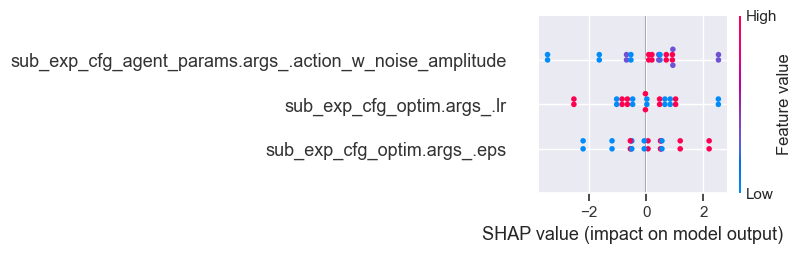

In [36]:
import shap
import xgboost
import pandas as pd


# Define the target metric and hyperparameter columns
target_metric = "episode_rewards_mean"  # Replace with actual metric column name
# Replace with actual hyperparameter column names

# Prepare data
X = sub_df[hyperparam_columns].apply(pd.to_numeric, errors='coerce')
y = sub_df[target_metric].fillna(3 * sub_df[target_metric].min())

# Train an XGBoost model to analyze feature importance
model = xgboost.XGBRegressor(objective="reg:squarederror", n_estimators=100, random_state=42)
model.fit(X, y)

# SHAP analysis
explainer = shap.Explainer(model)
shap_values = explainer(X)

# Summary plot (feature importance)
shap.summary_plot(shap_values, X)

In [37]:
hyperparam_columns

['sub_exp_cfg_optim.args_.eps',
 'sub_exp_cfg_optim.args_.lr',
 'sub_exp_cfg_agent_params.args_.action_w_noise_amplitude']

In [38]:
import plotly.express as px

# Define readable names for selected hyperparams
readable_names = {
    hyperparam_columns[0]: "noise",
    hyperparam_columns[1]: "size"
}

# Rename columns in a copy of the dataframe
plot_df = sub_df.rename(columns=readable_names)

# Assign new column names
x_col = "noise"
y_col = "episode_rewards_mean"
facet_col = "size"

# Plot
fig = px.scatter(
    plot_df,
    x=x_col,
    y=y_col,
    color="experiment_name",  # Optional: color by experiment
    facet_col=facet_col,
    title="Episode Rewards vs. Noise Faceted by Size",
    height=600
)

fig.update_layout(showlegend=False)
fig.show()
